In [1]:
import pennylane as qml
import pennylane.numpy as np

In [2]:
from circuit import *

In [3]:
interface = 'autograd'

In [4]:
if interface == 'autograd':
    import pennylane.numpy as np
    dev = qml.device("default.qubit", wires=range(3))
    params = 0.05 * np.ones(18)

elif interface == 'jax':
    import jax
    import jax.numpy as jnp
    # next line raises TypeError with default.qubit.jax
    # dev = qml.device("default.qubit.jax", wires=range(3))
    dev = qml.device("default.qubit", wires=range(3))
    params = jnp.array([0.05] * 18)
elif interface == 'torch':
    import torch
    dev = qml.device("default.qubit", wires=range(3))
    params = torch.tensor([0.05] * 18, requires_grad=True)

In [58]:
@qml.qnode(dev, interface=interface)
def three_spins_forward_state(params, delta_time, n=10):
    three_spins_circuit(params)
    qml.ApproxTimeEvolution(hamiltonian(), delta_time, n)
    return qml.state()

@qml.qnode(dev, interface=interface)
def three_spins_current_state(params):
    three_spins_circuit(params)
    return qml.state()

@qml.qnode(dev, interface=interface)
def three_spins_obvservables(params):
    three_spins_circuit(params)
    return [qml.expval(qml.PauliX(i)) for i in range(3)]


In [30]:
# test this works

dt = 0.1
original_state = three_spins_current_state(params)
forward_state = three_spins_forward_state(params + 0.01, dt)

qml.math.fidelity(original_state, forward_state)

0.975326007460802

In [31]:
prev_params = params
recorded_params = [params]


def cost_function(params):
    
    original_state = three_spins_current_state(prev_params)
    forward_state = three_spins_forward_state(params, dt)

    fidelity = qml.math.fidelity(original_state, forward_state)
    return 1 - fidelity


recorded_costs = [cost_function(params)]


In [32]:
cost_function(np.random.random(18))

0.8073579522614504

In [33]:

opt = qml.GradientDescentOptimizer(stepsize=0.1)


for n in range(max_iterations):
    params, prev_cost = opt.step_and_cost(cost_function, params)
    
    recorded_costs.append(cost_function(params))
    recorded_params.append(params)
    
    if recorded_costs[-1] < 0.0001:
        break
    

In [60]:
total_time = 2.0
#total_time = 0.5
dt = 0.05
max_iterations = 50
cost_threshold = 0.0001

prev_params = params

def cost_function(params):
    
    original_state = three_spins_current_state(prev_params)
    forward_state = three_spins_forward_state(params, dt)

    fidelity = qml.math.fidelity(original_state, forward_state)
    return 1 - fidelity


opt = qml.GradientDescentOptimizer(stepsize=0.1)

final_costs_v_time = {}
full_costs_v_time = {}
final_params_v_time = {}
full_params_v_time = {}
failed_to_converge_times = {}
observables = {}

In [61]:

for current_time in np.arange(0, total_time+dt, dt):
    print(current_time)
    
    prev_params = params
    recorded_params = [params]

    recorded_costs = [cost_function(params)]

    for n in range(max_iterations):
        params, prev_cost = opt.step_and_cost(cost_function, params)

        recorded_costs.append(cost_function(params))
        recorded_params.append(params)

        if recorded_costs[-1] <= cost_threshold:
            break

    if recorded_costs[-1] > cost_threshold:
        failed_to_converge_times[current_time] = recorded_costs[-1]
        
    observables[current_time] = three_spins_obvservables(params)
    final_costs_v_time[current_time] = recorded_costs[-1]
    full_costs_v_time[current_time] = recorded_costs
    final_params_v_time[current_time] = recorded_params[-1]
    full_params_v_time[current_time] = recorded_params

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0
1.05
1.1
1.1500000000000001
1.2000000000000002
1.25
1.3
1.35
1.4000000000000001
1.4500000000000002
1.5
1.55
1.6
1.6500000000000001
1.7000000000000002
1.75
1.8
1.85
1.9000000000000001
1.9500000000000002
2.0


In [62]:
final_costs_v_time

{tensor(0., requires_grad=True): 9.895369932721998e-05,
 tensor(0.05, requires_grad=True): 9.808867824001588e-05,
 tensor(0.1, requires_grad=True): 9.792681786913171e-05,
 tensor(0.15, requires_grad=True): 9.81034927226565e-05,
 tensor(0.2, requires_grad=True): 9.67727780797345e-05,
 tensor(0.25, requires_grad=True): 9.97103300224289e-05,
 tensor(0.3, requires_grad=True): 9.001122492380276e-05,
 tensor(0.35, requires_grad=True): 8.557000579734186e-05,
 tensor(0.4, requires_grad=True): 8.992439225097293e-05,
 tensor(0.45, requires_grad=True): 8.737930518643022e-05,
 tensor(0.5, requires_grad=True): 9.34988137779591e-05,
 tensor(0.55, requires_grad=True): 9.209167404600205e-05,
 tensor(0.6, requires_grad=True): 9.77433465365607e-05,
 tensor(0.65, requires_grad=True): 9.813341585374058e-05,
 tensor(0.7, requires_grad=True): 9.794438118049253e-05,
 tensor(0.75, requires_grad=True): 9.915845793462275e-05,
 tensor(0.8, requires_grad=True): 0.00010147435489971102,
 tensor(0.85, requires_grad=

In [63]:
final_params_v_time

{tensor(0., requires_grad=True): tensor([ 2.36975895,  2.25945363,  2.36998356, -0.09884268, -0.09904031,
          0.04061005,  0.10531676,  0.04074647, -0.14436526, -0.14436422,
          2.69249898,  2.76635826,  2.69225586,  0.14994703,  0.14979034,
         -0.20940847, -0.28741727, -0.20923141], requires_grad=True),
 tensor(0.05, requires_grad=True): tensor([ 2.41787245,  2.30468415,  2.4180981 , -0.11826233, -0.11847023,
          0.02804776,  0.09254725,  0.02820263, -0.1594992 , -0.15950245,
          2.73658501,  2.80788666,  2.73634215,  0.15441095,  0.15424441,
         -0.20524315, -0.28661496, -0.20507884], requires_grad=True),
 tensor(0.1, requires_grad=True): tensor([ 2.46598599,  2.35001034,  2.46621104, -0.13675055, -0.13697065,
          0.01787058,  0.08256127,  0.01803964, -0.17414251, -0.1741515 ,
          2.78061964,  2.84912224,  2.78037734,  0.15613484,  0.15595801,
         -0.20190176, -0.28700073, -0.20175   ], requires_grad=True),
 tensor(0.15, requires_gr

In [64]:
observables

{tensor(0., requires_grad=True): tensor([-0.0413367 ,  0.00088357, -0.04127006], requires_grad=True),
 tensor(0.05, requires_grad=True): tensor([-0.04555256, -0.00424789, -0.04548008], requires_grad=True),
 tensor(0.1, requires_grad=True): tensor([-0.04885557, -0.00848333, -0.04877899], requires_grad=True),
 tensor(0.15, requires_grad=True): tensor([-0.05123607, -0.01146091, -0.051157  ], requires_grad=True),
 tensor(0.2, requires_grad=True): tensor([-0.05267184, -0.01294866, -0.05259202], requires_grad=True),
 tensor(0.25, requires_grad=True): tensor([-0.05318195, -0.01281627, -0.05310333], requires_grad=True),
 tensor(0.3, requires_grad=True): tensor([-0.05300721, -0.01161802, -0.05293145], requires_grad=True),
 tensor(0.35, requires_grad=True): tensor([-0.05230895, -0.00953616, -0.05223759], requires_grad=True),
 tensor(0.4, requires_grad=True): tensor([-0.05126474, -0.00678889, -0.05119907], requires_grad=True),
 tensor(0.45, requires_grad=True): tensor([-0.05014186, -0.00391968, -

In [66]:
import matplotlib.pyplot as plt

In [69]:
t = observables.keys()
v = observables.values()


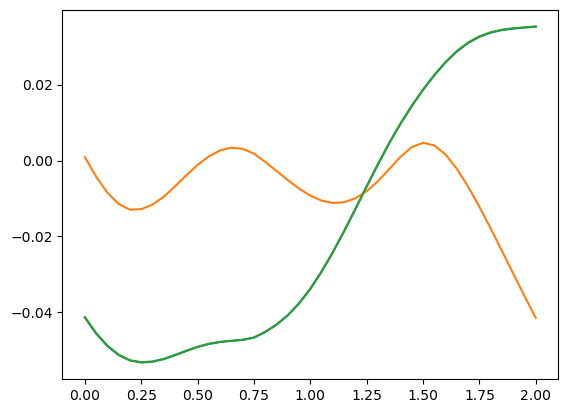

In [71]:
# expectation value of pauliX on qubit 0, 1 and 2 versus time.

plt.plot(t,v)